In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import matthews_corrcoef , confusion_matrix , accuracy_score , precision_score , recall_score
import pickle

Import dataset for VonHeijine and SVM analysis

In [2]:
dataset = pd.read_csv("../Data_Preparation/train_bench.tsv", sep = "\t")

Function definitions

In [4]:
from Bio.SeqUtils.ProtParam import ProteinAnalysis, ProtParamData
import statistics as st
# function to get the features

def get_scale_features (seq, scale ,window, output_type): 
        
    ''' This function returns the features (max score and average score) of a chosen scale for a specific sequence. You can use a personalized 
    dictionary of scores or a one inside ProtParamData. You can check all the ProtParamData scales using the command dir(ProtParamData) A legend of each 
    param argument is given at the beginning of this file'''

    sequence = ProteinAnalysis(seq) 
    if type(scale)==dict:   
        scale_result = sequence.protein_scale(scale, window, edge=1)
        if len(seq)<window:
            scale_result = sequence.protein_scale(scale, len(seq), edge=1)
    else:

        param_dict = getattr(ProtParamData, scale)
        scale_result = sequence.protein_scale(param_dict, window, edge=1)
        if len(seq)<window:
            scale_result = sequence.protein_scale(param_dict, len(seq), edge=1)
    max_value=max(scale_result)
    mean_value=st.mean(scale_result)
    if output_type == "mean" :
        return mean_value
    else:
        return max_value

 # Von Heijine PERFORMANCE

In [5]:
#!pip install importnb
import sys
from importnb import Notebook

# add the folder vonheijine that contains our vonheijine functions
sys.path.append("../vonHeijne/")

# import the notebook that contains the pswm creator and the testing of vonheijine
with Notebook():
    import create_pswm, validation_and_testing_vonheijne


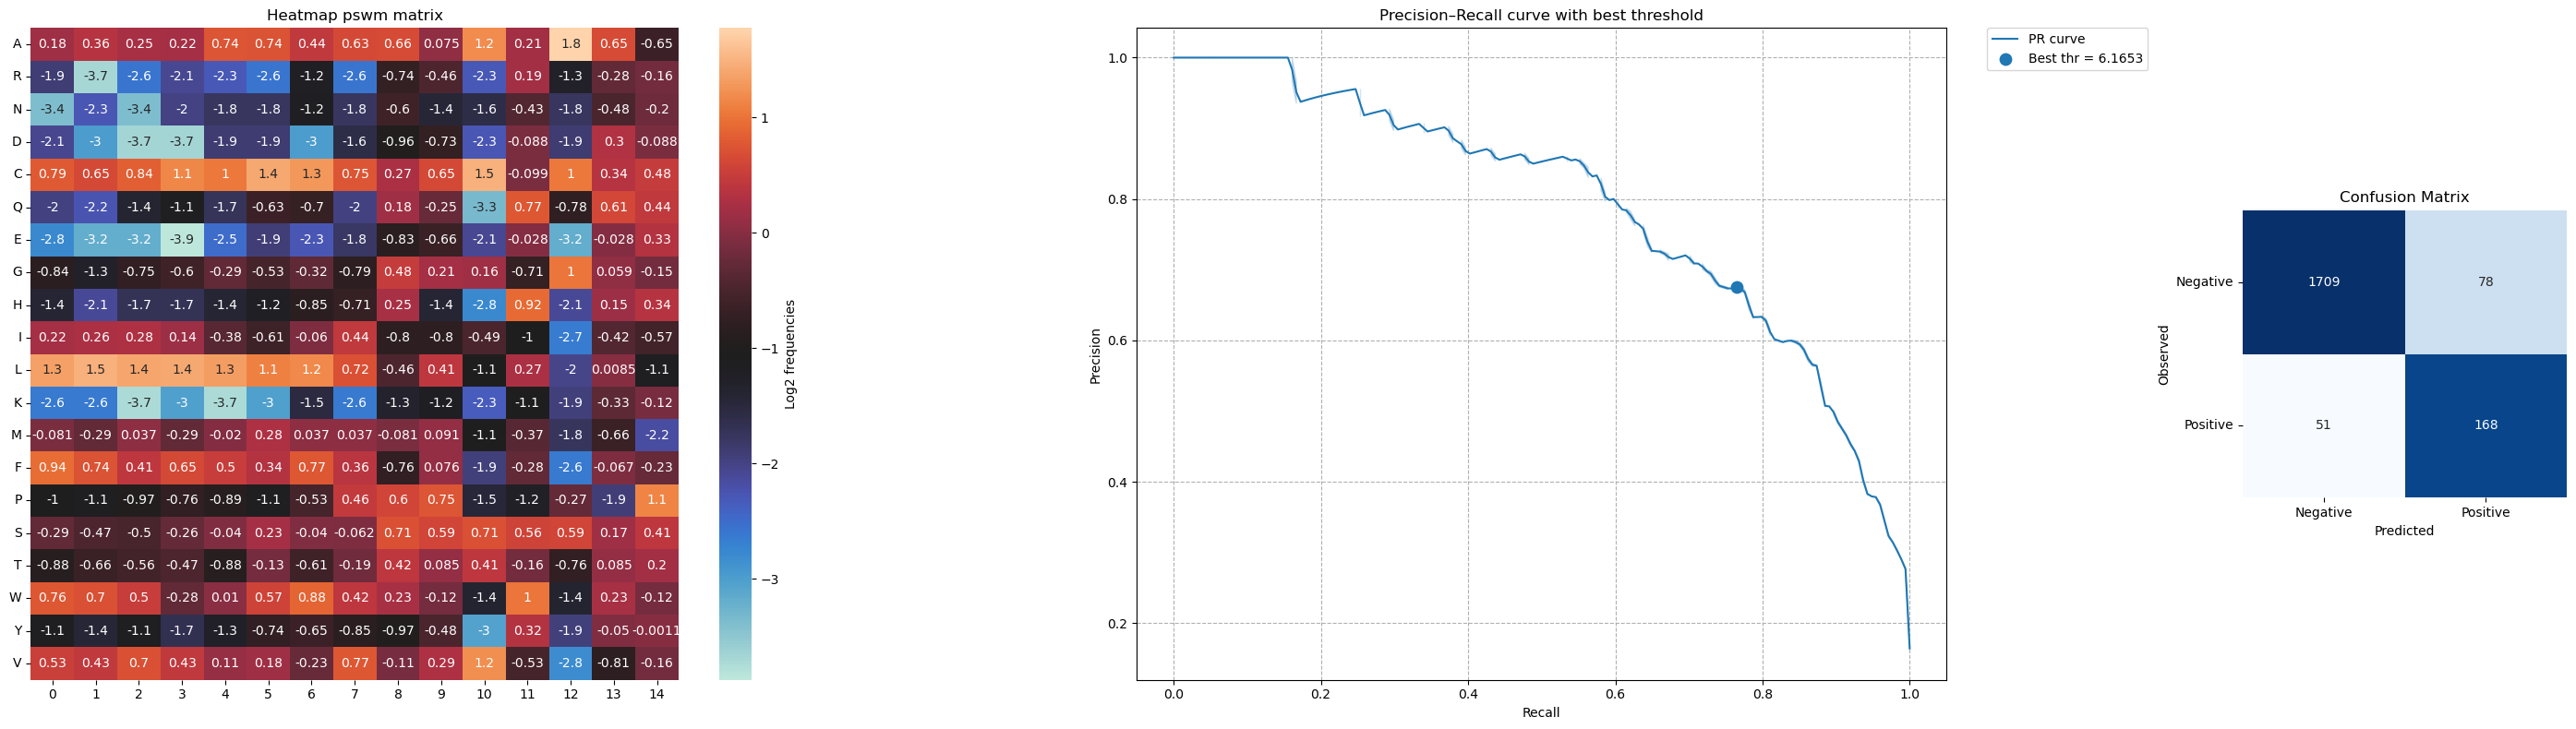

In [6]:
pswm=create_pswm.get_pswm(dataset.query("(Set=='1' or Set=='5' or Set=='3' or Set=='4') and Class=='Positive'"), 13,2)
stats=validation_and_testing_vonheijne.metrics(pswm, dataset.query("(Set=='2')") , dataset.query("Set=='Benchmark'"))

In [7]:
metrics_name = ["MCC", "Precision", "Accuracy", "Sensitivity" , "Confusion Matrix"]
for name, stat in zip(metrics_name,stats): 
    if name=="Confusion Matrix":
        confusion_df = pd.DataFrame(stat, columns=["Negative" , "Positive"], index=["Negative", "Positive"])
        print(f"{name} : \n{confusion_df}")
    else:    
        print(f"{name} = {stat}")

MCC = 0.6878342596948499
Precision = 0.9356929212362911
Accuracy = 0.6829268292682927
Sensitivity = 0.7671232876712328
Confusion Matrix : 
          Negative  Positive
Negative      1709        78
Positive        51       168


# SVM PERFORMANCE

Import the final model and predict the benchmark set

In [8]:
#import the final model
with open('SignalPeptideSVM.pkl', 'rb') as f:
    final_classifier = pickle.load(f)
# load testing
loaded_data_test = np.load('benchmark_features.npz')
x_test = loaded_data_test['matrix']
y_test = loaded_data_test['target']

bench_pred = final_classifier.predict(x_test)

/home/luca/anaconda3/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.7.2 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/luca/anaconda3/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.7.2 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/luca/anaconda3/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.7.2 when using version 1.5.1. This might lead to brea

Compute SVM metrics

SVM Metrics:
MCC = 0.8081691772560898 
Precision = 0.8272727272727273 
Sensitivity = 0.8310502283105022 
Accuracy = 0.9626121635094715


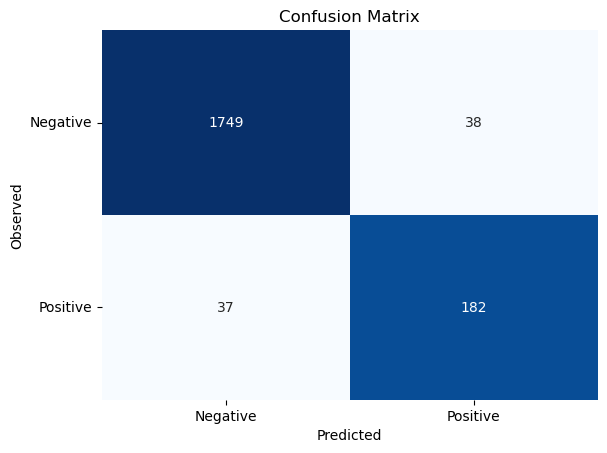

In [9]:
conf_mat = confusion_matrix( y_test, bench_pred)
svm_mcc = matthews_corrcoef(y_test , bench_pred)
svm_precision = precision_score(y_test , bench_pred)
svm_sensitivity = recall_score(y_test , bench_pred)
svm_accuracy = accuracy_score(y_test , bench_pred)
print(f"SVM Metrics:\nMCC = {svm_mcc} \nPrecision = {svm_precision} \nSensitivity = {svm_sensitivity} \nAccuracy = {svm_accuracy}")
sns.heatmap(
        conf_mat,
        annot=True,
        cmap="Blues",
        fmt="d",
        cbar=False,
        vmax = 200      
    )
plt.xlabel("Predicted")
plt.ylabel("Observed")  
plt.title("Confusion Matrix")  
plt.xticks(ticks=[0.5, 1.5], labels=["Negative", "Positive"])
plt.yticks(ticks=[0.5, 1.5], labels=["Negative", "Positive"], rotation=0)
plt.show()

Get position of false positive and false negative proteins

In [10]:
svm_fp = []
svm_fn = []
#create lists of indexes of the false positive and false negative proteins
for i in range(len(y_test)):
    if bench_pred[i] == 0 and y_test[i] == 1:
        svm_fn.append(i) #we are appending i, that is a row index
    elif bench_pred[i] == 1 and y_test[i] == 0:
        svm_fp.append(i)
    else:
        pass

Create a new tsv file containing information about SVM prediction outcome

In [11]:
# now import the dataset and create dataframes that only contain data of interest
benchmark=dataset.query("Set=='Benchmark'")
false_positives_df = benchmark.iloc[svm_fp] #dataframe with only fp entries
false_negatives_df = benchmark.iloc[svm_fn] #dataframe with only fn entries
true_positives_df = benchmark.query("Class == 'Positive'") #dataframe with only tp entries
true_negatives_df = benchmark.query("Class == 'Negative'") #dataframe with only tn entries

# create a new column in the benchmark dataframe to store information about classification
rows = benchmark.shape[0]
classification_col = []
for i in range(rows):
    # if the row number is in svm_fp or svm_fn, append FP or FN to the classification column
    if i in svm_fp:
        classification_col.append("FP")
        continue
    elif i in svm_fn:
        classification_col.append("FN")
        continue
    #if the row number is not in svm_fp or svm_fn lists, it means the corresponding entry is correctly classified
    elif benchmark.iloc[i]["Class"] == "Negative":
        classification_col.append("TN")
    elif benchmark.iloc[i]["Class"] == "Positive":
        classification_col.append("TP")

#create new dataframe "prediction_dataset"
prediction_dataset=benchmark.copy()
prediction_dataset["Prediction"]=classification_col


#save as a standalone file
prediction_dataset.to_csv('benchmark_predictions.tsv', sep='\t', index=False)

In [12]:
#some checks on the new dataframe:

print(prediction_dataset.shape , benchmark.shape)
print(prediction_dataset.query("Prediction == 'FP'").shape[0])
print(prediction_dataset.query("Prediction == 'FN'").shape[0])

(2006, 11) (2006, 10)
38
37


Plotting

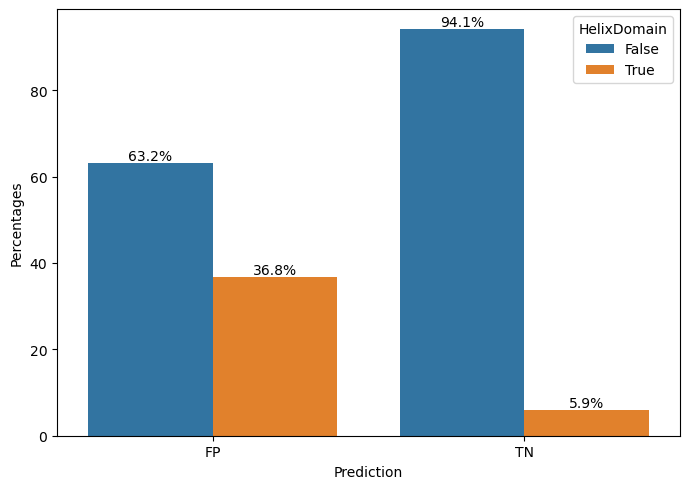

In [13]:
# make counts in function of prediction and helix domain presence
counts = (
    prediction_dataset
    .groupby(["Prediction", "HelixDomain"])
    .size()
    .rename("n")
    .reset_index()
)

# compute percentage within each prediction group relative to its own size
counts["percent"] = counts.groupby("Prediction")["n"].transform(lambda s: ( s / s.sum())*100)

# plot the histogram
plt.figure(figsize=(7,5))
ax = sns.barplot(data=counts, x="Prediction", y="percent", hue="HelixDomain")
ax.set_ylabel("Percentages")
ax.set_xlabel("Prediction")
ax.legend(title="HelixDomain")
for c in ax.containers:
    ax.bar_label(c, fmt="%.1f%%")
    
plt.tight_layout()
plt.savefig("model_evaluation/HelixDomain_predictions.png", dpi=300)
plt.show()


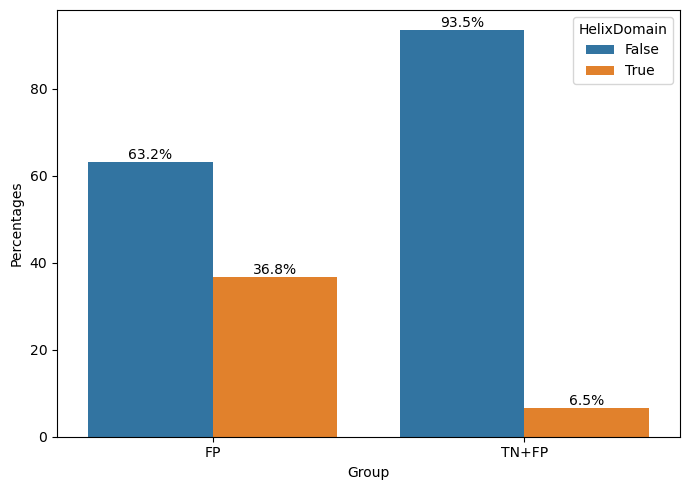

In [14]:
# create the subset with all negatives (fp+tn) and a version with only the fp

all_negatives=prediction_dataset.query("Class=='Negative'").copy()
all_negatives['Group']="TN+FP" #change this to change the label on the x-axis
false_positive=prediction_dataset.query("Prediction=='FP'").copy()
false_positive['Group']="FP" #change this to change the label on the x-axis
counts_group=pd.concat([false_positive,all_negatives], ignore_index=True)

# make counts in function of group and helix domain presence
counts = (
    counts_group
    .groupby(["Group", "HelixDomain"])
    .size()
    .rename("n")
    .reset_index()
)
# compute percentage within fp group and total negatives relative to its own size
counts["percent"] = counts.groupby("Group")["n"].transform(lambda s: ( s / s.sum())*100)

# make the plot
plt.figure(figsize=(7,5))
ax = sns.barplot(data=counts, x="Group", y="percent", hue="HelixDomain")
ax.set_ylabel("Percentages")
ax.set_xlabel("Group")
ax.legend(title="HelixDomain")
for c in ax.containers:
    ax.bar_label(c, fmt="%.1f%%")
plt.tight_layout()
plt.savefig("model_evaluation/HD_prediction_2.png", dpi=300)
plt.show()
plt.show()

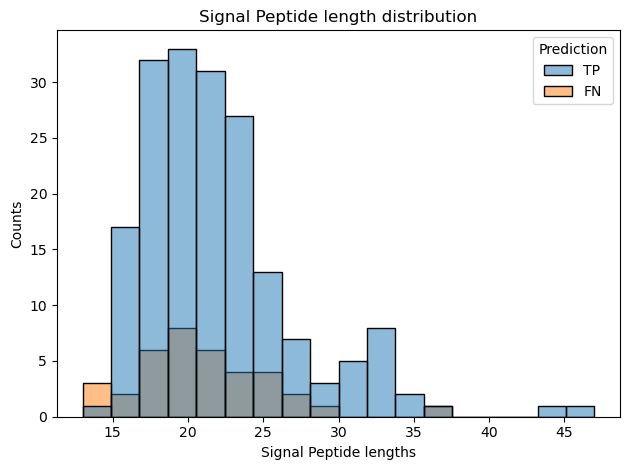

In [15]:
#signal peptide length distribution histogram
length_df = prediction_dataset.query("Class == 'Positive'").copy()
length_df["sp_length"] = prediction_dataset["SPEnd"] - prediction_dataset["SPStart"]

sns.histplot(
    data=length_df,
    x="sp_length",
    hue="Prediction",
)

plt.title("Signal Peptide length distribution")
plt.ylabel("Counts")
plt.xlabel("Signal Peptide lengths")

plt.tight_layout()
plt.savefig("model_evaluation/Signalength_distribution.png", dpi=300)
plt.show()

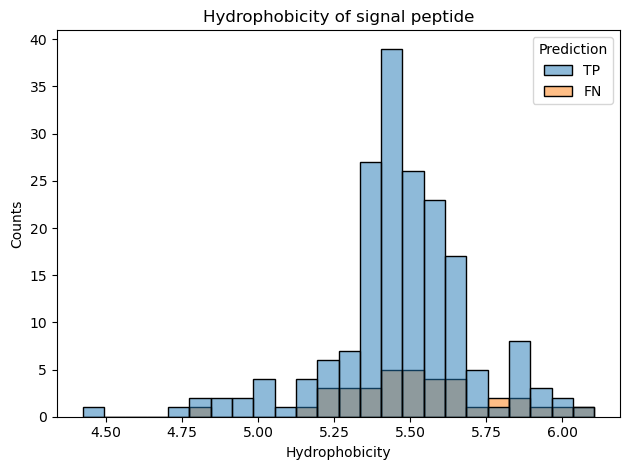

In [16]:
#hydrophobicity distribution

hydro_df = prediction_dataset.query("Class == 'Positive'").copy()

hydro_df["hydrophobicity"] = hydro_df.apply(
    lambda row: get_scale_features(row["Sequence"], "mi", int(row["SPEnd"] - row["SPStart"]) , "mean"),
    axis=1
)

sns.histplot(
    data=hydro_df,
    x="hydrophobicity",
    hue="Prediction",
    
)

plt.title("Hydrophobicity of signal peptide")
plt.ylabel("Counts")
plt.xlabel("Hydrophobicity")

plt.tight_layout()
plt.savefig("model_evaluation/Hydrophobicity_distribution.png", dpi=300)
plt.show()



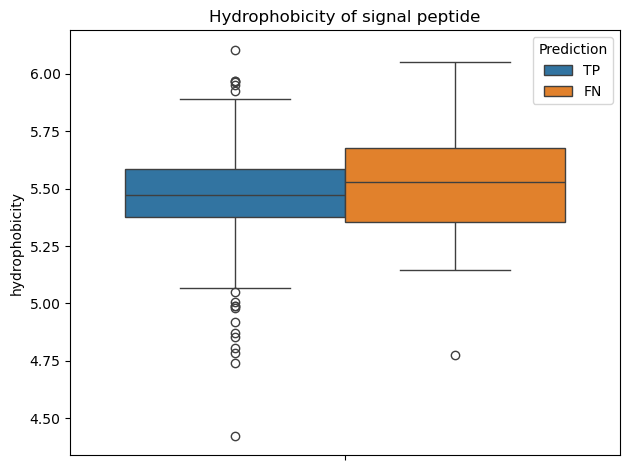

In [17]:
sns.boxplot(
    data=hydro_df,
    y="hydrophobicity",
    hue="Prediction",
    
)

plt.title("Hydrophobicity of signal peptide")
plt.tight_layout()
plt.savefig("model_evaluation/Boxplot_hydrophobicity.png", dpi=300)
plt.show()

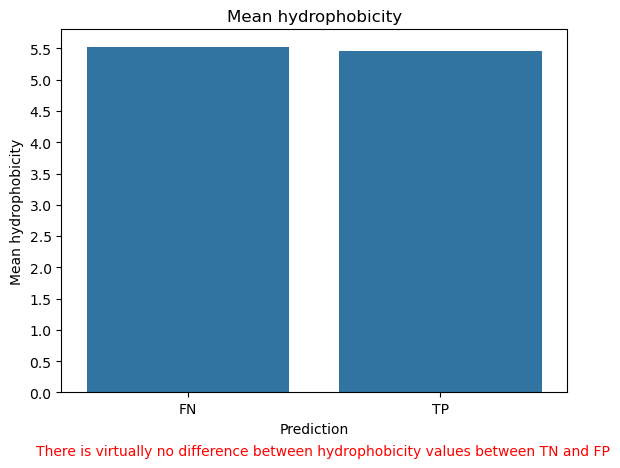


 Prediction
FN    5.526798
TP    5.461668
Name: hydrophobicity, dtype: float64 



In [18]:
# mean hydrophobicity percentage
import seaborn as sns
import matplotlib.pyplot as plt

hydro_means = hydro_df.groupby('Prediction')['hydrophobicity'].mean()

sns.barplot(x=hydro_means.index, y=hydro_means.values)

y_ticks = [i/10 for i in range(0, 60, 5)]
plt.ylabel("Mean hydrophobicity")  
plt.yticks(y_ticks)
plt.title("Mean hydrophobicity")
plt.text(-0.6, -1, "There is virtually no difference between hydrophobicity values between TN and FP", color='red', fontsize=10)
plt.tight_layout()
plt.savefig("model_evaluation/Mean_hydrophobicity.png", dpi=300)
plt.show()
print("\n", hydro_means ,"\n")

False Positive Rate comparison

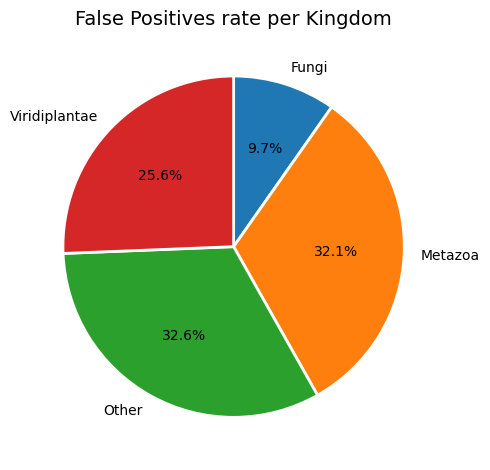

In [19]:
#pie plot with false positive for kingdom classification
false_positives=prediction_dataset.query("Prediction=='FP'")
counts_falsepositive = (
    false_positives
    .groupby(["Kingdom", "Prediction"])
    .size()
    .rename("n")
    .reset_index()
)

counts_falsepositive["total"]=counts_falsepositive["Kingdom"].map(benchmark.query("Class=='Negative'").groupby(["Kingdom"]).size())
counts_falsepositive["percent"] = counts_falsepositive.groupby("Kingdom")["n"].transform(lambda s: ( s / counts_falsepositive["total"])*100)
fig, ax = plt.subplots()
ax.pie(
    counts_falsepositive["percent"],
    labels=counts_falsepositive["Kingdom"],
    autopct="%.1f%%",
    startangle=90,            
    counterclock=False,        
    wedgeprops={"linewidth": 2, "edgecolor": "white"}
)
ax.set_title("False Positives rate per Kingdom", fontsize=14)
ax.set_aspect("equal")         
plt.tight_layout()
plt.savefig("model_evaluation/pieplot_kingdom_FPR.png", dpi=300)
plt.show()

/home/luca/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


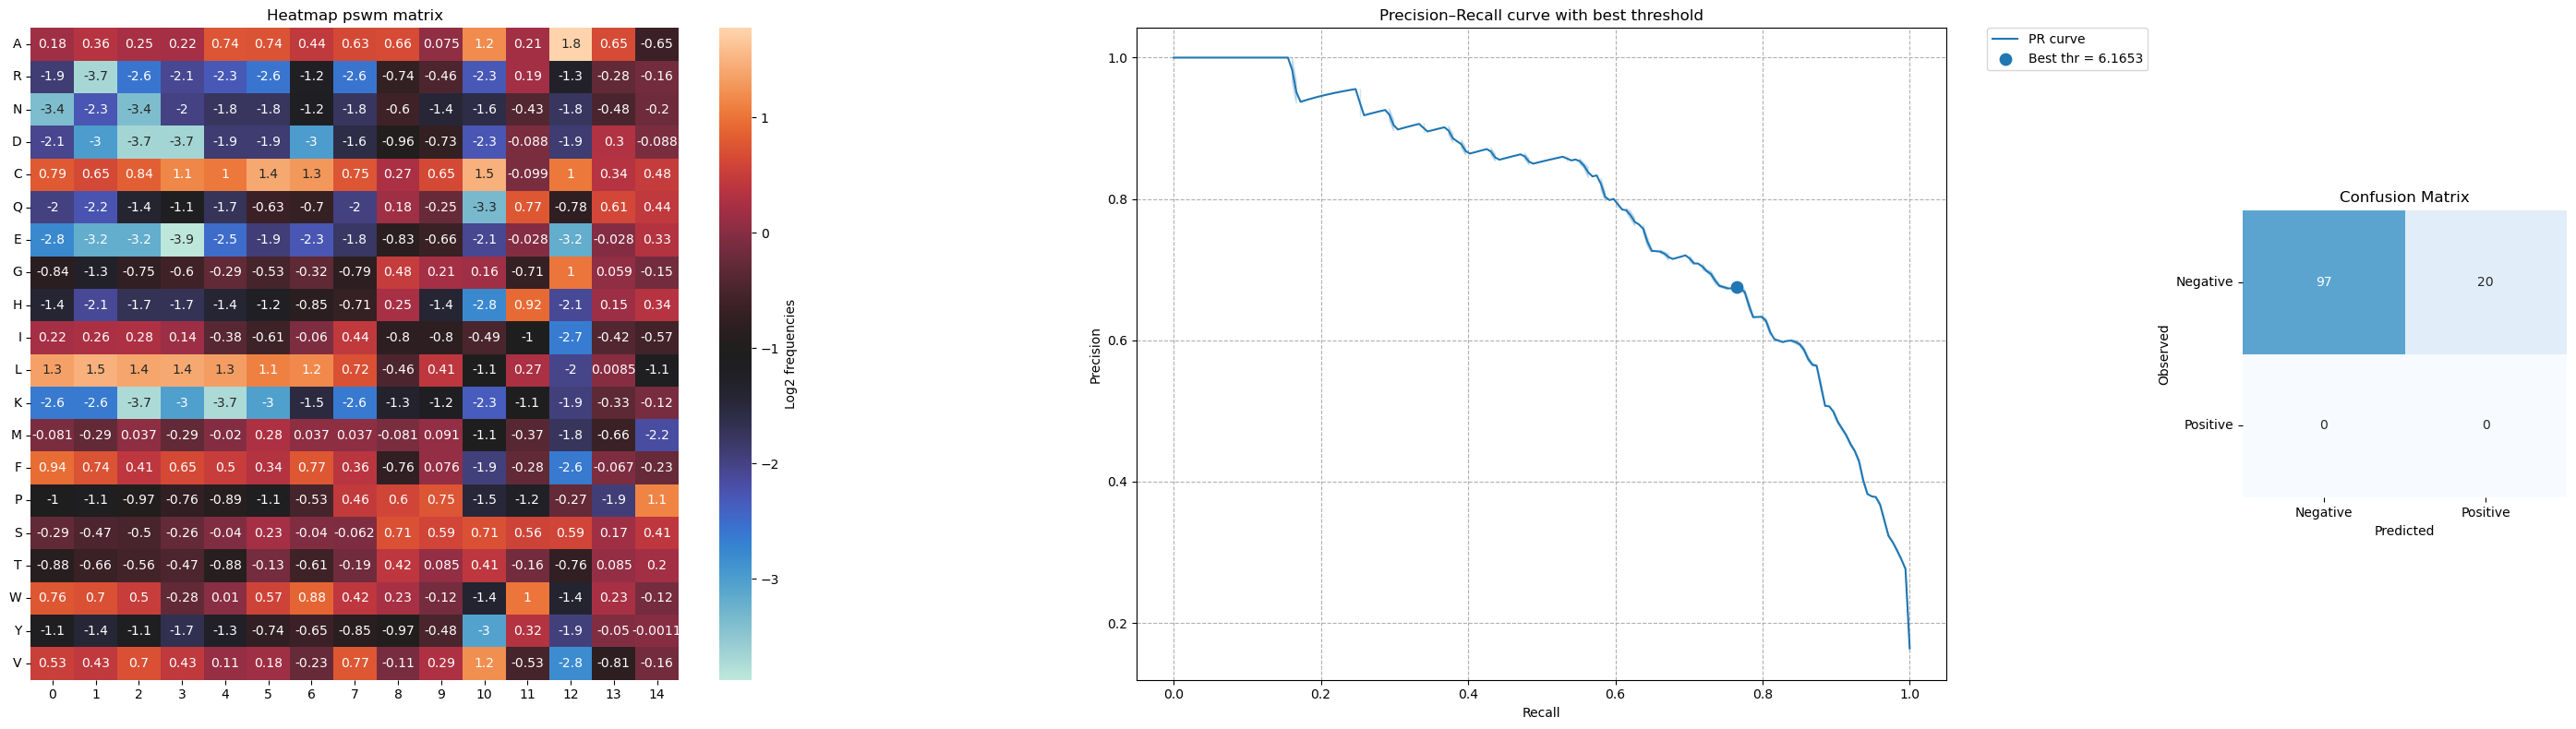

In [20]:
#fpr SVM

#compute the fpr on the entire dataset
fpr_svm=len(false_positives)/len(benchmark.query("Class=='Negative'"))
fpr_helix_svm=len(false_positive.query("HelixDomain==True"))/len(benchmark.query("Class=='Negative' and HelixDomain==True"))

#fpr von heijine method

#compute fpr as counts of false positives divided by all positives (false positives + true negatives)
fpr_von=int(confusion_df['Positive']['Negative'])/(int((confusion_df['Positive']['Negative']))+int(confusion_df['Negative']['Negative']))
#fpr von heijne method on transmembrane domain proteins only
#we have to "test" the vonheijine method on transmembrane proteins only
stats_hd=validation_and_testing_vonheijne.metrics(pswm, dataset.query("(Set=='2')") , dataset.query("Set=='Benchmark' and HelixDomain==True"))
confusion_df_hd = pd.DataFrame(stats_hd[4], columns=["Negative" , "Positive"], index=["Negative", "Positive"])
fpr_von_hd=int(confusion_df_hd['Positive']['Negative'])/(int((confusion_df_hd['Positive']['Negative']))+int(confusion_df_hd['Negative']['Negative']))

In [21]:
print("FPR SVM:",fpr_svm)
print("FPR SVM only on transmembrane proteins:", fpr_helix_svm)
print("FPR Von Heijne:",fpr_von)
print("FPR Von Heijne on transmembrane proteins:" , fpr_von_hd ,"\n")
print("Considerations:\nVonHeijne method showed a "+str(round((fpr_svm/fpr_von)*100 , 1))+"% increase in FPR compared to the SVM.")
print("On transmembrane proteins VonHeijne method showed a "+str(round((fpr_helix_svm/fpr_von_hd)*100 , 1))+"% increase in FPR compared to the SVM")

FPR SVM: 0.021264689423614997
FPR SVM only on transmembrane proteins: 0.11965811965811966
FPR Von Heijne: 0.04364857302742026
FPR Von Heijne on transmembrane proteins: 0.17094017094017094 

Considerations:
VonHeijne method showed a 48.7% increase in FPR compared to the SVM.
On transmembrane proteins VonHeijne method showed a 70.0% increase in FPR compared to the SVM


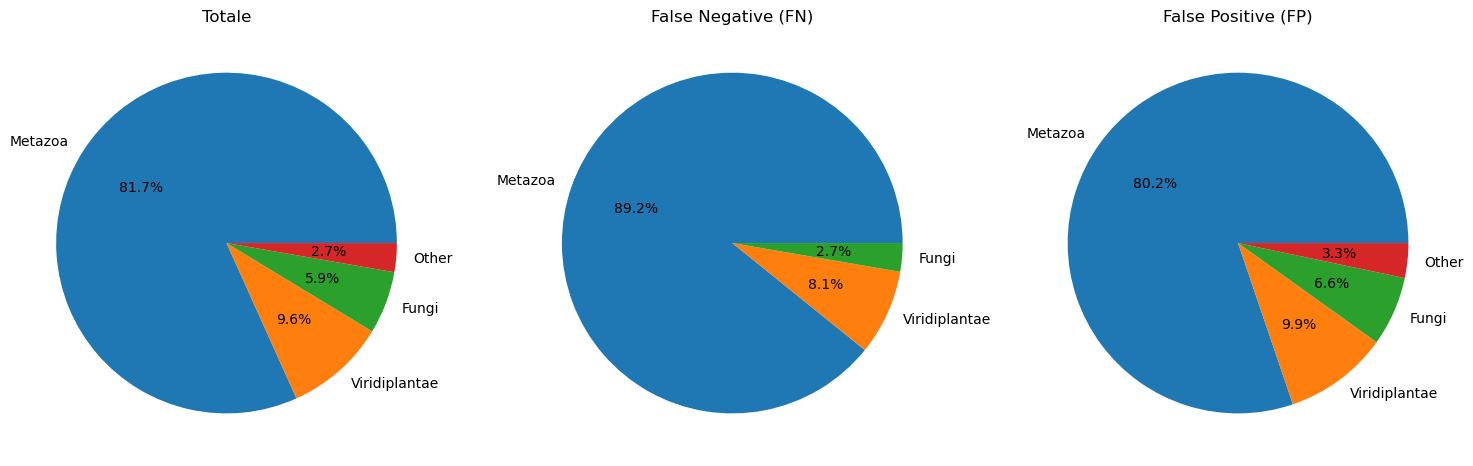

In [22]:
# Taxonomic Composition of False Negatives, False Positives and Total Predictions
taxa_df=prediction_dataset.query("Class == 'Positive'").copy()

counts_total = taxa_df['Kingdom'].value_counts()
counts_fn = taxa_df[taxa_df['Prediction'] == 'FN']['Kingdom'].value_counts()
counts_fp = taxa_df[taxa_df['Prediction'] == 'TP']['Kingdom'].value_counts()


fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].pie(counts_total, labels=counts_total.index, autopct='%1.1f%%')
axes[0].set_title('Totale')

axes[1].pie(counts_fn, labels=counts_fn.index, autopct='%1.1f%%')
axes[1].set_title('False Negative (FN)')

axes[2].pie(counts_fp, labels=counts_fp.index, autopct='%1.1f%%')
axes[2].set_title('False Positive (FP)')

plt.tight_layout()
plt.savefig("model_evaluation/Taxa_composition_FP_FN.png", dpi=300)
plt.show()


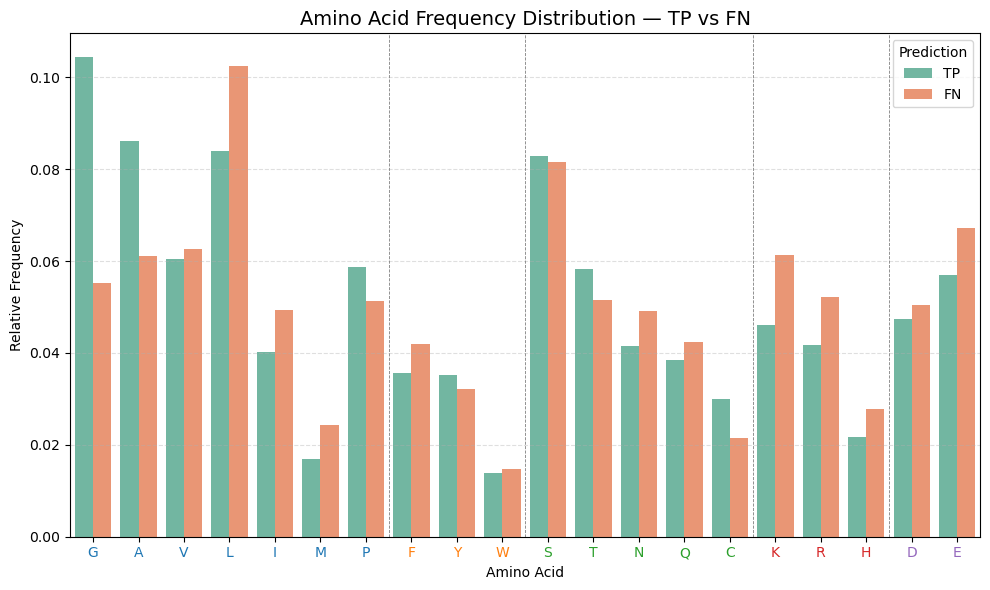

In [24]:
# TP_freq e FN_freq have to be residue-indexed Series (es. index=['A','C',...])
TP_df_sequence = prediction_dataset[prediction_dataset["Prediction"] == "TP"][["Sequence"]].copy()
FN_df_sequence = prediction_dataset[prediction_dataset["Prediction"] == "FN"][["Sequence"]].copy()

def aa_frequency(df):
    all_seq = "".join(df["Sequence"])
    total = len(all_seq)
    freq = {aa: all_seq.count(aa) / total for aa in set(all_seq)}
    return pd.Series(freq).sort_index()
TP_freq = aa_frequency(TP_df_sequence)
FN_freq = aa_frequency(FN_df_sequence)
# Merge the two Pandas Series (TP_freq and FN_freq) for the plot

aa_compare = pd.DataFrame({
    "TP": TP_freq,
    "FN": FN_freq
}).fillna(0)

aa_compare = (
    aa_compare.reset_index()
              .melt(id_vars="index", var_name="Group", value_name="Frequency")
              .rename(columns={"index": "AminoAcid"})
)
aa_compare = pd.DataFrame({"TP": TP_freq, "FN": FN_freq}).fillna(0)

aa_compare = (
    aa_compare.reset_index()
              .melt(id_vars="index", var_name="Group", value_name="Frequency")
              .rename(columns={"index": "AminoAcid"})
)

aa_categories = {
    'nonpolar': list("GAVLIMP"),
    'aromatic': list("FYW"),
    'polar':    list("STNQC"),
    'positive': list("KRH"),
    'negative': list("DE"),
}

aa_order = [
    'G','A','V','L','I','M','P',
    'F','Y','W',
    'S','T','N','Q','C',
    'K','R','H',
    'D','E'
]

# mapping AA
res_to_cat = {aa: cat for cat, aas in aa_categories.items() for aa in aas}
aa_compare["AminoAcid"] = pd.Categorical(aa_compare["AminoAcid"], categories=aa_order, ordered=True)

plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=aa_compare,
    x="AminoAcid",
    y="Frequency",
    hue="Group",
    order=aa_order,
    palette="Set2"
)

ax.set_title("Amino Acid Frequency Distribution — TP vs FN", fontsize=14)
ax.set_xlabel("Amino Acid")
ax.set_ylabel("Relative Frequency")
ax.grid(axis='y', linestyle="--", alpha=0.4)
ax.legend(title="Prediction")

# label color based on category
cat_colors = {
    'nonpolar':'#1f77b4',
    'aromatic':'#ff7f0e',
    'polar':'#2ca02c',
    'positive':'#d62728',
    'negative':'#9467bd'
}
for label in ax.get_xticklabels():
    aa = label.get_text()
    cat = res_to_cat.get(aa)
    if cat:
        label.set_color(cat_colors[cat])

# separating lines between groups
group_boundaries = []
current_cat = None
for i, aa in enumerate(aa_order):
    cat = res_to_cat[aa]
    if current_cat is None:
        current_cat = cat
    elif cat != current_cat:
        group_boundaries.append(i - 0.5)
        current_cat = cat

for x in group_boundaries:
    ax.axvline(x=x, color='gray', linestyle='--', linewidth=0.6)

plt.tight_layout()
plt.show()

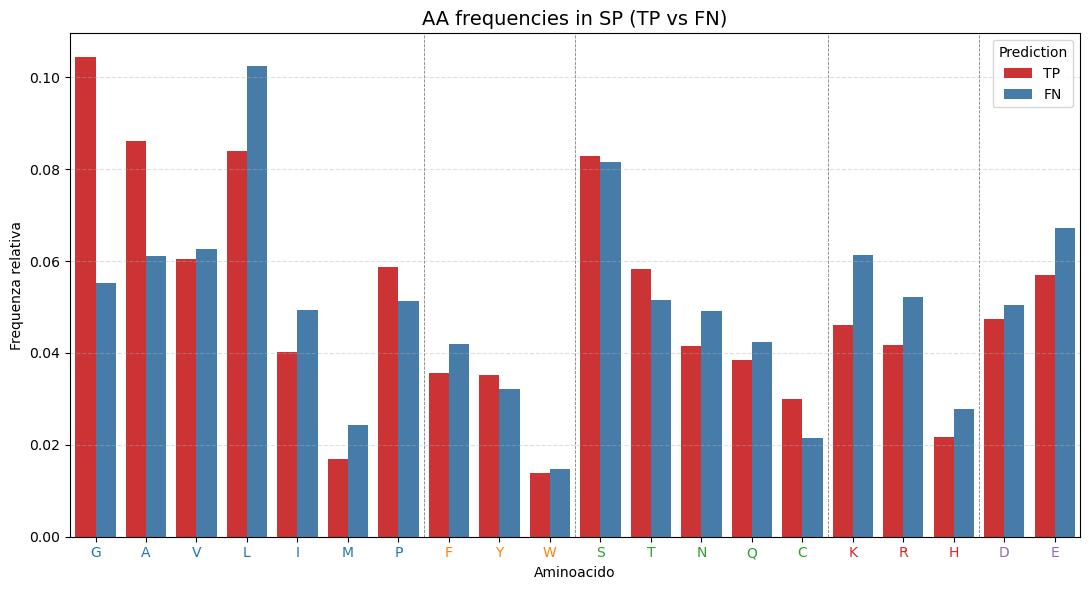

In [25]:
SP_df = prediction_dataset[prediction_dataset["Prediction"].isin(["TP", "FN"])][["SPStart", "SPEnd", "Sequence", "Prediction"]].copy()

def SP_aa_frequency(df):
    for index, row in df.iterrows():
        seq = row["Sequence"]
        start = int(row["SPStart"]) - 1
        end = int(row["SPEnd"])
        df.loc[index, "SPSequence"] = seq[start:end]
    return df

SP_df = SP_aa_frequency(SP_df)

def SP_frequency(df, label):
    label_df = df[df["Prediction"] == label]
    all_seq = "".join(label_df["SPSequence"].dropna().astype(str))
    total = len(all_seq)
    if total == 0:
        return pd.Series(dtype=float)
    unique_aa = sorted(set(all_seq))
    freq = {aa: all_seq.count(aa) / total for aa in unique_aa}
    return pd.Series(freq)


TP_ser = SP_frequency(SP_df, "TP").rename("TP")
FN_ser = SP_frequency(SP_df, "FN").rename("FN")

freq_df = pd.concat([TP_ser, FN_ser], axis=1).fillna(0)






plt.figure(figsize=(11, 6))
ax = sns.barplot(
    data=aa_compare,
    x="AminoAcid",
    y="Frequency",
    hue="Group",
    order=aa_order,
    palette="Set1"
)
ax.set_title("AA frequencies in SP (TP vs FN)", fontsize=14)
ax.set_xlabel("Aminoacido")
ax.set_ylabel("Frequenza relativa")
ax.grid(axis="y", linestyle="--", alpha=0.4)
ax.legend(title="Prediction")

# separating lines between groups
cat_colors = {
    "nonpolar":"#1f77b4",
    "aromatic":"#ff7f0e",
    "polar":"#2ca02c",
    "positive":"#d62728",
    "negative":"#9467bd"
}
for tick in ax.get_xticklabels():
    aa = tick.get_text()
    cat = res_to_cat.get(aa)
    if cat:
        tick.set_color(cat_colors[cat])

# separating lines between categories
group_boundaries = []
current_cat = None
for i, aa in enumerate(aa_order):
    cat = res_to_cat[aa]
    if current_cat is None:
        current_cat = cat
    elif cat != current_cat:
        group_boundaries.append(i - 0.5)
        current_cat = cat

for x in group_boundaries:
    ax.axvline(x=x, color="gray", linestyle="--", linewidth=0.6, zorder=0)
    
plt.tight_layout()
plt.savefig("model_evaluation/AA_fequencies_3.png", dpi=300)
plt.show()

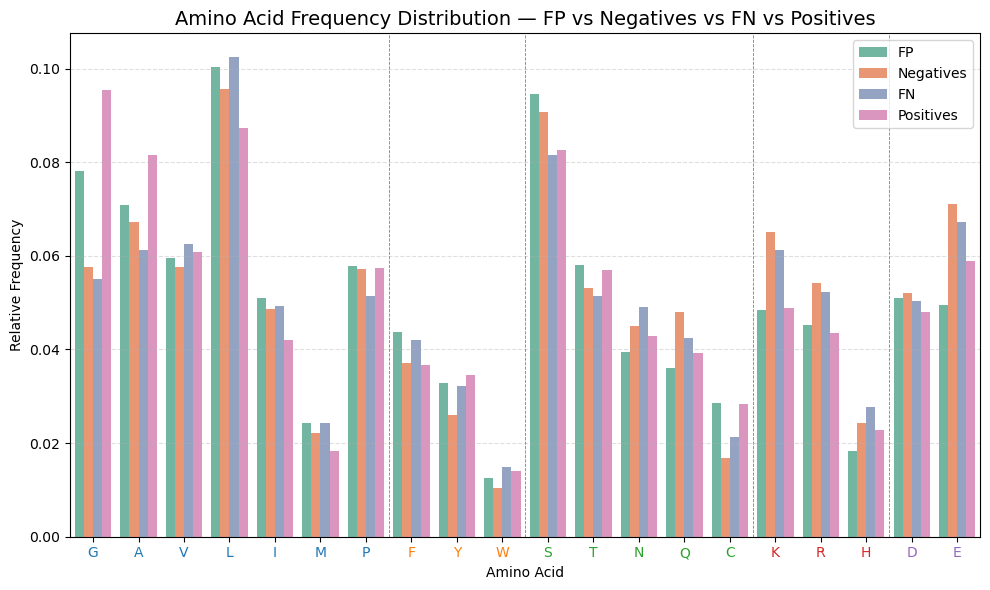

In [26]:
#we now compare aa frequencies among all positives, all negatives, false positives and false negatives
FP_df_sequence = prediction_dataset[prediction_dataset["Prediction"] == "FP"][["Sequence"]].copy()
#FN_df_sequence = prediction_dataset[prediction_dataset["Prediction"] == "FN"][["Sequence"]].copy()
PP_df_sequence = prediction_dataset[prediction_dataset["Class"] == "Positive"][["Sequence"]].copy()
NN_df_sequence = prediction_dataset[prediction_dataset["Class"] == "Negative"][["Sequence"]].copy()

FP_freq = aa_frequency(FP_df_sequence)
#FN_freq = aa_frequency(FN_df_sequence)
PP_freq = aa_frequency(PP_df_sequence)
NN_freq = aa_frequency(NN_df_sequence)


# TP_freq e FN_freq have to be residue-indexed Series (es. index=['A','C',...])
aa_compare_tot = pd.DataFrame({"FP": FP_freq, "Negatives" : NN_freq , "FN": FN_freq , "Positives" : PP_freq}).fillna(0)

aa_compare_tot = (
    aa_compare_tot.reset_index()
              .melt(id_vars="index", var_name="Group", value_name="Frequency")
              .rename(columns={"index": "AminoAcid"})
)
aa_order = [
    'G','A','V','L','I','M','P',
    'F','Y','W',
    'S','T','N','Q','C',
    'K','R','H',
    'D','E'
]

# mapping AA
aa_categories = {
    'nonpolar': list("GAVLIMP"),
    'aromatic': list("FYW"),
    'polar':    list("STNQC"),
    'positive': list("KRH"),
    'negative': list("DE"),
}
cat_colors = {
    "nonpolar":"#1f77b4",
    "aromatic":"#ff7f0e",
    "polar":"#2ca02c",
    "positive":"#d62728",
    "negative":"#9467bd"
}



res_to_cat = {aa: cat for cat, aas in aa_categories.items() for aa in aas}
aa_compare_tot["AminoAcid"] = pd.Categorical(aa_compare_tot["AminoAcid"], categories=aa_order, ordered=True)

plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=aa_compare_tot,
    x="AminoAcid",
    y="Frequency",
    hue="Group",
    order=aa_order,
    palette="Set2"
)

ax.set_title("Amino Acid Frequency Distribution — FP vs Negatives vs FN vs Positives", fontsize=14)
ax.set_xlabel("Amino Acid")
ax.set_ylabel("Relative Frequency")
ax.grid(axis='y', linestyle="--", alpha=0.4)
ax.legend()

for label in ax.get_xticklabels():
    aa = label.get_text()
    cat = res_to_cat.get(aa)
    if cat:
        label.set_color(cat_colors[cat])

group_boundaries = []
current_cat = None
for i, aa in enumerate(aa_order):
    cat = res_to_cat[aa]
    if current_cat is None:
        current_cat = cat
    elif cat != current_cat:
        group_boundaries.append(i - 0.5)
        current_cat = cat

for x in group_boundaries:
    ax.axvline(x=x, color='gray', linestyle='--', linewidth=0.6)

plt.tight_layout()
plt.savefig("model_evaluation/figure9.png", dpi=300)
plt.show()

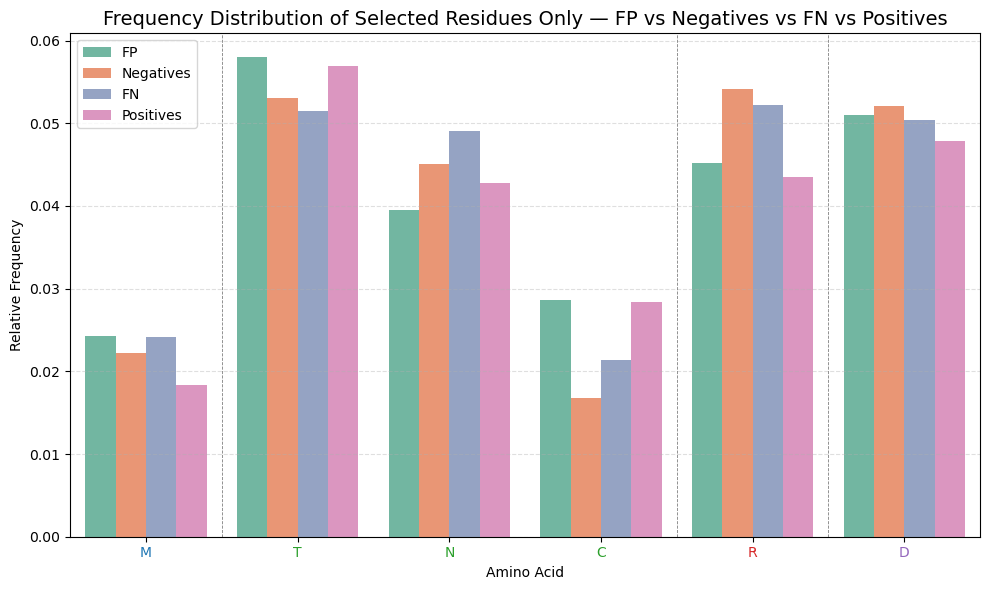

In [27]:
#we now compare selected aa frequencies among all positives, all negatives, false positives and false negatives

def sel_aa_frequency(df):
    all_seq = "".join(df["Sequence"])
    total = len(all_seq)
    freq = {aa: all_seq.count(aa) / total for aa in ['M','T','N','C','R','D']}
    return pd.Series(freq).sort_index()

sel_FP_freq = sel_aa_frequency(FP_df_sequence)
sel_FN_freq = sel_aa_frequency(FN_df_sequence)
sel_PP_freq = sel_aa_frequency(PP_df_sequence)
sel_NN_freq = sel_aa_frequency(NN_df_sequence)

#selected residues are: C , D , T , R , N , M
sel_aa_order = ['M','T','N','C','R','D']

# TP_freq e FN_freq have to be residue-indexed Series (es. index=['A','C',...])
aa_compare_sel = pd.DataFrame({"FP": sel_FP_freq, "Negatives" : sel_NN_freq , "FN": sel_FN_freq , "Positives" : sel_PP_freq}).fillna(0)

aa_compare_sel = (
    aa_compare_sel.reset_index()
              .melt(id_vars="index", var_name="Group", value_name="Frequency")
              .rename(columns={"index": "AminoAcid"})
)

sel_aa_categories = {
    'nonpolar': list("M"),
    'polar':    list("TNC"),
    'positive': list("R"),
    'negative': list("D"),
}


# mapping AA
sel_res_to_cat = {aa: cat for cat, aas in sel_aa_categories.items() for aa in aas}
aa_compare_sel["AminoAcid"] = pd.Categorical(aa_compare_sel["AminoAcid"], categories=sel_aa_order, ordered=True)

plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=aa_compare_sel,
    x="AminoAcid",
    y="Frequency",
    hue="Group",
    order=sel_aa_order,
    palette="Set2"
)

ax.set_title("Frequency Distribution of Selected Residues Only — FP vs Negatives vs FN vs Positives", fontsize=14)
ax.set_xlabel("Amino Acid")
ax.set_ylabel("Relative Frequency")
ax.grid(axis='y', linestyle="--", alpha=0.4)
ax.legend()

for label in ax.get_xticklabels():
    aa = label.get_text()
    cat = res_to_cat.get(aa)
    if cat:
        label.set_color(cat_colors[cat])

group_boundaries = []
current_cat = None
for i, aa in enumerate(sel_aa_order):
    cat = sel_res_to_cat[aa]
    if current_cat is None:
        current_cat = cat
    elif cat != current_cat:
        group_boundaries.append(i - 0.5)
        current_cat = cat

for x in group_boundaries:
    ax.axvline(x=x, color='gray', linestyle='--', linewidth=0.6)

plt.tight_layout()
plt.savefig("model_evaluation/AA_distribution_single.png", dpi=300)
plt.show()

Sequence Logos

In [28]:
import logomaker as lm 

#Lets analyse FP , FN , TP , TN

#create sequence lists 
logo_pos_seqs=[]
logo_neg_seqs=[]
logo_fn_seqs=[]
logo_fp_seqs=[]


logo_neg = prediction_dataset.query("Class == 'Negative'")
#To make a logo, all sequences need to have the same length
for index,row in logo_neg.iterrows():
    sequence_to_recover=row["Sequence"]
    logo_neg_seqs.append(sequence_to_recover[1:18])
    if row["Prediction"]=="FP":
        logo_fp_seqs.append(sequence_to_recover[1:18])
    
logo_pos = prediction_dataset.query("Class == 'Positive'")
for index,row in logo_pos.iterrows():
    sequence_to_recover=row["Sequence"]
    cleavage_position=int(row["SPEnd"])
    logo_pos_seqs.append(sequence_to_recover[cleavage_position-13:cleavage_position+4])
    if row["Prediction"]=="FN":
        logo_fn_seqs.append(sequence_to_recover[cleavage_position-13:cleavage_position+4])

logo_fullseqs=[logo_pos_seqs ,logo_fn_seqs, logo_neg_seqs , logo_fp_seqs]



Sequence Logos computed using Information Content


<Figure size 600x1400 with 0 Axes>

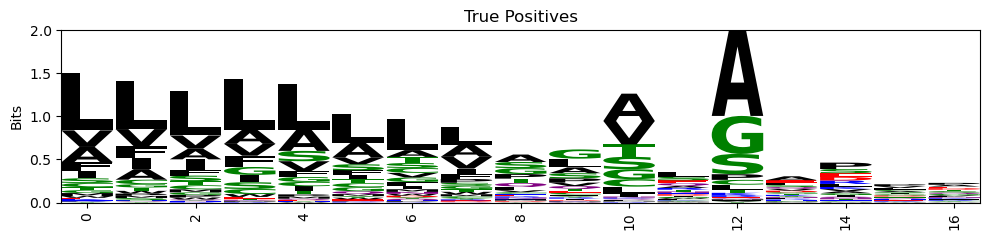

<Figure size 600x1400 with 0 Axes>

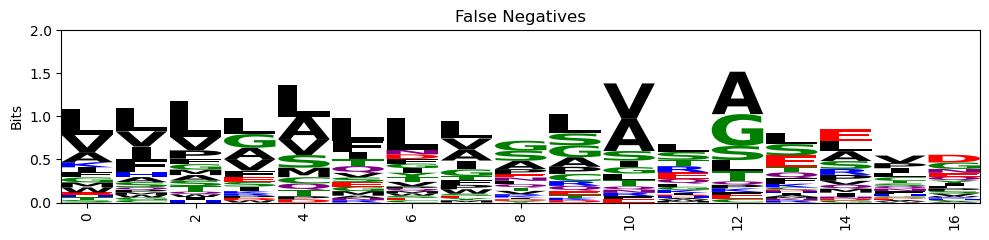

<Figure size 600x1400 with 0 Axes>

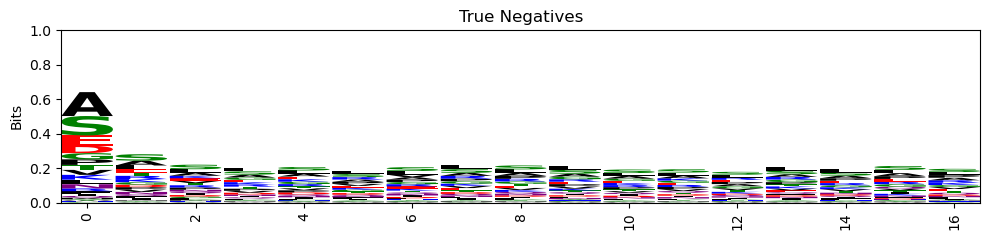

<Figure size 600x1400 with 0 Axes>

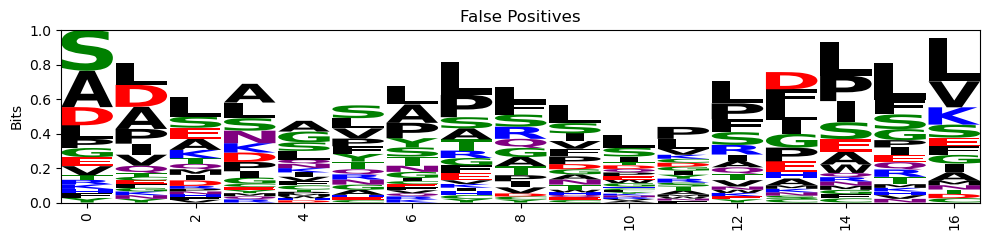

Sequence Logos computed using Probability of residues


<Figure size 600x1400 with 0 Axes>

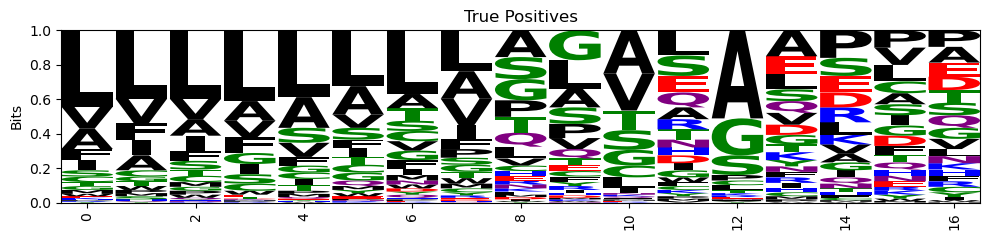

<Figure size 600x1400 with 0 Axes>

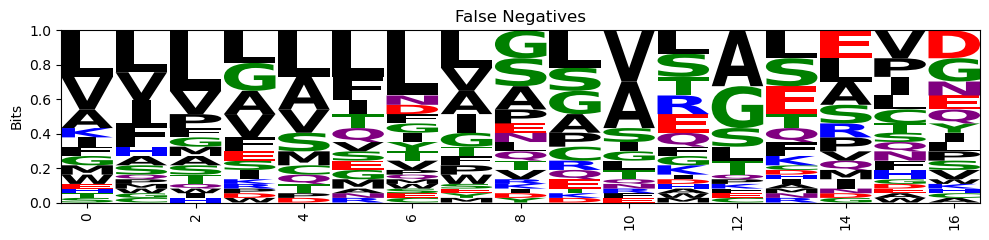

<Figure size 600x1400 with 0 Axes>

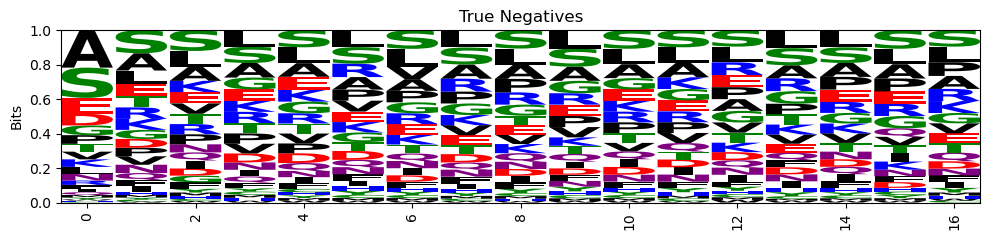

<Figure size 600x1400 with 0 Axes>

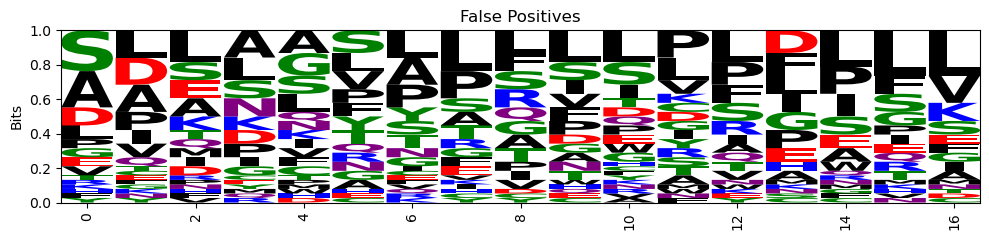

In [29]:
# Sequence logo --> metric = information content
count=1
print("Sequence Logos computed using Information Content")
for i , j in zip(logo_fullseqs , ["True Positives" , "False Negatives", "True Negatives" , "False Positives" ]):
    #create an alignment matrix
    logo_mat=lm.alignment_to_matrix(sequences=i, to_type='information',characters_to_ignore='.-X', pseudocount=0 )
    #plot the sequence logo
    plt.figure(figsize=(6,14))
    lm.Logo(logo_mat, shade_below=.5, fade_below=.5, color_scheme="chemistry")
    plt.xticks(rotation=90)
    plt.ylabel("Bits")
    if j in ["True Negatives" , "False Positives" ]:
        plt.ylim(0, 1.0)  # Adjust the maximum Y-axis limit
    else:
        plt.ylim(0, 2.0)  # Adjust the maximum Y-axis limit
    plt.title(j)
    plt.tight_layout()
    plt.savefig(f"model_evaluation/figure12A-{count}.png", dpi=300)
    plt.show()
    count=count+1

# Sequence logo --> metric = probability
count=1
print("Sequence Logos computed using Probability of residues")
for i , j in zip(logo_fullseqs , ["True Positives" , "False Negatives", "True Negatives" , "False Positives" ]):
    #create an alignment matrix
    logo_mat=lm.alignment_to_matrix(sequences=i, to_type='probability',characters_to_ignore='.-X', pseudocount=0 )
    #plot the sequence logo
    plt.figure(figsize=(6,14))
    lm.Logo(logo_mat, shade_below=.5, fade_below=.5, color_scheme="chemistry")
    plt.xticks(rotation=90)
    plt.ylabel("Bits")
    plt.title(j)
    plt.tight_layout()
    plt.savefig(f"model_evaluation/Sequence_Logo-{count}.png", dpi=300) 
    plt.show()
    count=count+1

#### HYPOTESIS1:  
FPR could be higher in plants due to the presence in this group only of the transit peptides (TP), that has a similar structure to that of the signal peptide (SP)  
We have to investigate if the presence of the TP in plants can confound the SVM classifier  

#### HYPOTHESIS2:  
The most abundant plant species in the dataset is by far Arabidopsis thaliana.  
If the FPR in plant entries is found to be almost equal to that of the other entries, we still have to investigate if our model was only able to correctly classify Arabidopsis plant entries, and if true, perform supplementary analysis to discover why  

In [30]:
# Viridaeplante analysis
plant_df = prediction_dataset.query("Kingdom == 'Viridiplantae'")
print("False Positive rate in plant entries: "+str(plant_df.query("Prediction == 'FP'").shape[0] / plant_df.query("Class == 'Negative'").shape[0]))
print("False Positive rate in entire benchmark set:" , fpr_svm)
print("\nIn total we have "+str(plant_df.shape[0])+" entries")
print("Out of all entries in plant kingdom "+str(plant_df.query("OrganismName == 'Arabidopsis thaliana'").shape[0])+" of them are from Arabidopsis")

fpr_ara = plant_df.query("OrganismName == 'Arabidopsis thaliana' and Prediction == 'FP'").shape[0] / plant_df.query("OrganismName == 'Arabidopsis thaliana' and Class == 'Negative'").shape[0]
print("False Positive rate in Arabidopsis entries:" , fpr_ara)

fpr_not = plant_df.query("OrganismName != 'Arabidopsis thaliana' and Prediction == 'FP'").shape[0] / plant_df.query("OrganismName != 'Arabidopsis thaliana' and Class == 'Negative'").shape[0]
print("False Positive rate in all other entries:", fpr_not)

False Positive rate in plant entries: 0.021875
False Positive rate in entire benchmark set: 0.021264689423614997

In total we have 341 entries
Out of all entries in plant kingdom 265 of them are from Arabidopsis
False Positive rate in Arabidopsis entries: 0.023076923076923078
False Positive rate in all other entries: 0.016666666666666666


The FPR in plant entries is only slightly higher than that of the entire benchmark dataset, suggesting that our model can correctly distinguish TP and SP  

The FPR in Arabidopsis entries is surprisingly higher than that of all the plant entries, however by a small amount  
FPR in all other entries is instead way lower than that of the entire benchmark set, however, with only 76 entries, that could be due to noise  
I don't think statistical tests are needed   
Marco Centenaro

### Supplementary analysis on most informative features

In [31]:
def scale_function(df , val_dict , output_type): #output_type can be mean or max
    value_list=[]
    for seq in df:
        seq=seq.replace("X" , "")
        seq=seq.replace("U" , "C")
        value = get_scale_features(seq, val_dict, 15 ,output_type)
        value_list.append(value)
    return value_list

In [32]:
selected_features=['VhonHeijne',
                   'C', 
                   'tm_tendency_max', 
                   'chou_fasman_h_mean',
                   'max_miyazawa_mean',  #miazawa = hydrophobicity
                   'D', 
                   'T', 
                   'R',
                   'chou_fasma_b_max',
                   'N', 
                   'flexibility_max',
                   'punta_max',
                   'bulkiness_mean',
                   'M',
                   'argos_max']

In [33]:
# max transmembrane tendency

#same scale we used for computing the feature
tm_tendency_custom = {'A':  0.380, 'R': -2.570,'N': -1.620,'D': -3.270,'C': -0.300,'Q': -1.840,'E': -2.900,'G': -0.190,'H': -1.440,'I':  1.970,'L':  1.820,'K': -3.460,'M':  1.400,'F':  1.980,'P': -1.440,    'S': -0.530,     'T': -0.320,     'W':  1.530,     'Y':  0.490,    'V':  1.400  }

max_tm = scale_function(prediction_dataset["Sequence"], tm_tendency_custom, "max")

In [34]:
#ignore pandas warning
pd.options.mode.chained_assignment = None

# create tm_tendency dataframe

tm_df = prediction_dataset.copy()
tm_df["Max Transmembrane Tendency"]=max_tm

tm_all_positives=tm_df.query("Class == 'Positive'")
tm_all_positives["Group"]="Positive"

tm_all_negatives=tm_df.query("Class == 'Negative'")
tm_all_negatives["Group"]="Negative"

tm_fp=tm_df.query("Prediction == 'FP'")
tm_fp["Group"]="Falsea Positive"

tm_fn=tm_df.query("Prediction == 'FN'")
tm_fn["Group"]="False Negative"


tm_ready = pd.concat([tm_all_positives , tm_all_negatives , tm_fp , tm_fn] , axis=0 )

#### Max Transmembrane Tendency Plots

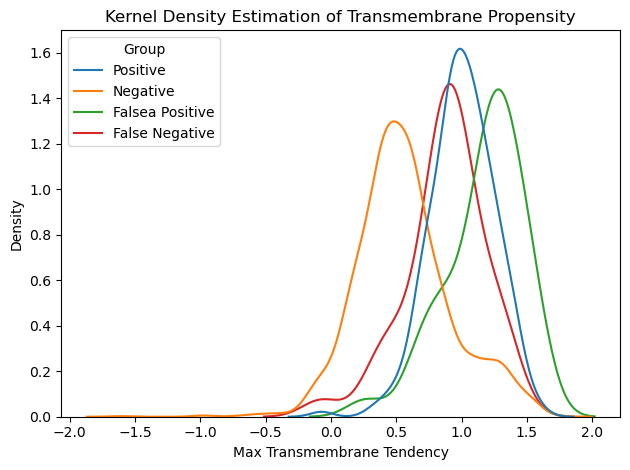

In [35]:
sns.kdeplot(
    data=tm_ready,
    x="Max Transmembrane Tendency",
    hue="Group",
    common_norm=False
)
plt.title("Kernel Density Estimation of Transmembrane Propensity")
plt.tight_layout()
plt.savefig("model_evaluation/KDE_TranmembranP.png", dpi=300)
plt.show()

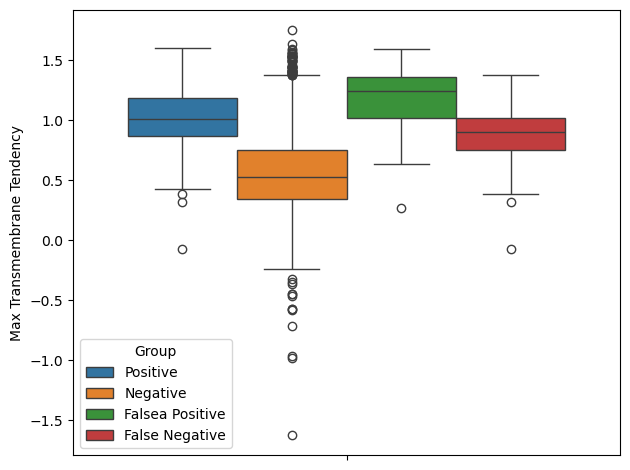

In [36]:
sns.boxplot(
    data=tm_ready,
    y="Max Transmembrane Tendency",
    hue="Group", 
)

plt.tight_layout()
plt.savefig("model_evaluation/Boxplot_TRTE.png", dpi=300)
plt.show()

In [37]:
# chou_fasman_h --> residue helix propensity
# chou famsan_b --> residue beta-sheet propensity

chou_fasman_h = {"A": 1.42, "L": 1.21, "R": 0.98, "K": 1.16, "N": 0.67, "M": 1.45, "D": 1.01, "F": 1.13, "C": 0.70, "P": 0.57, "Q": 1.11, "S": 0.77, "E": 1.51, "T": 0.83, "G": 0.57, "W": 1.08, "H": 1.00, "Y": 0.69, "I": 1.08, "V": 1.06}
chou_fasman_b = {"A": 0.83, "L": 1.30, "R": 0.93, "K": 0.74, "N": 0.89, "M": 1.05, "D": 0.54, "F": 1.38, "C": 1.19, "P": 0.55, "Q": 1.10, "S": 0.75, "E": 0.37, "T": 1.19, "G": 0.75, "W": 1.37, "H": 0.87, "Y": 1.47, "I": 1.60, "V": 1.70}

mean_cfh = scale_function(prediction_dataset["Sequence"], chou_fasman_h, "mean")
max_cfb = scale_function(prediction_dataset["Sequence"] , chou_fasman_b , "max")

In [38]:
# create chou_fasman dataframe

cf_df = prediction_dataset.copy()
cf_df["Chou-Fasman helix propensity (mean)"]=mean_cfh
cf_df["Chou-Fasman beta-sheet propensity (max)"]=max_cfb

cf_all_positives=cf_df.query("Class == 'Positive'")
cf_all_positives["Group"]="Positive"

cf_all_negatives=cf_df.query("Class == 'Negative'")
cf_all_negatives["Group"]="Negative"

cf_fp=cf_df.query("Prediction == 'FP'")
cf_fp["Group"]="False Positive"

cf_fn=cf_df.query("Prediction == 'FN'")
cf_fn["Group"]="False Negative"

cf_ready = pd.concat([cf_all_positives , cf_all_negatives , cf_fp , cf_fn] , axis=0 )

#### Chou-Fasman helix and beta-sheet propensity plots

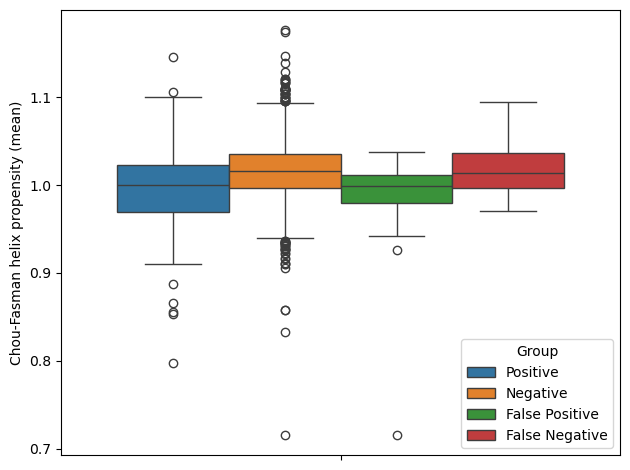

In [39]:
sns.boxplot(
    data=cf_ready,
    y="Chou-Fasman helix propensity (mean)",
    hue="Group" 
)

plt.tight_layout()
plt.savefig("model_evaluation/Boxplot_Chou_Fasman.png", dpi=300)
plt.show()

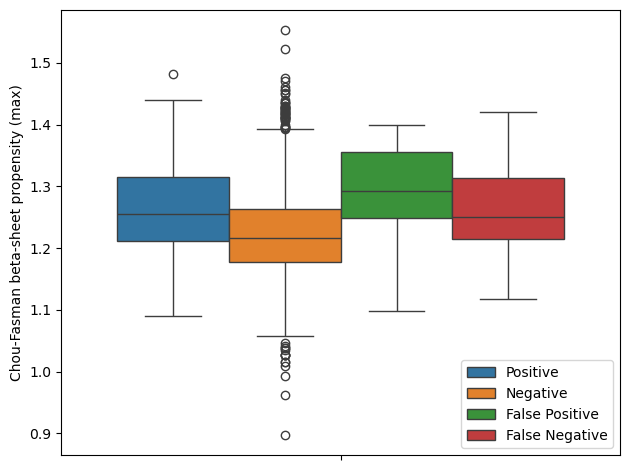

In [40]:
sns.boxplot(
    data=cf_ready,
    y="Chou-Fasman beta-sheet propensity (max)",
    hue="Group"
)

plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig("model_evaluation/Chou_Fasman_BProp.png", dpi=300)
plt.show()

In [41]:
# flexibility

flexibility = scale_function(prediction_dataset["Sequence"], "Flex", "max")

In [42]:
# create flexibility dataframe

flex_df = prediction_dataset.copy()
flex_df["Residue Flexibility (max)"]=flexibility

flex_all_positives=flex_df.query("Class == 'Positive'")
flex_all_positives["Group"]="Positive"

flex_all_negatives=flex_df.query("Class == 'Negative'")
flex_all_negatives["Group"]="Negative"

flex_fp=flex_df.query("Prediction == 'FP'")
flex_fp["Group"]="False Positive"

flex_fn=flex_df.query("Prediction == 'FN'")
flex_fn["Group"]="False Negative"

flex_ready = pd.concat([flex_all_positives , flex_all_negatives , flex_fp , flex_fn] , axis=0 )

#### Residue Flexibility plot

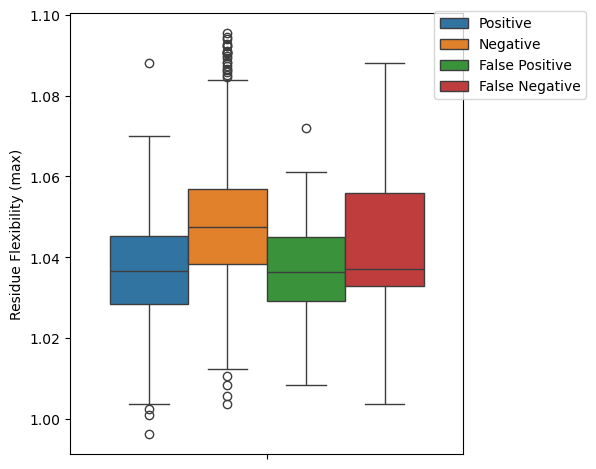

In [43]:
sns.boxplot(
    data=flex_ready,
    y="Residue Flexibility (max)",
    hue="Group" 
)
plt.legend(loc='upper right', bbox_to_anchor=(1.33, 1.02))
plt.tight_layout()
plt.savefig("model_evaluation/Boxplot_ResidueFlex.png", dpi=300)
plt.show()

In [44]:
# punta_max (membrane-propensity scale) --> knowledge based membrane propensity (Punta-Maritan, 2003)

punta_scale = {"A": -0.17, "L": -0.28, "R": 0.37, "K": 0.32, "N": 0.18, "M": -0.26, "D": 0.37, "F": -0.41, "C": -0.06, "P": 0.13, "Q": 0.26, "S": 0.05, "E": 0.15, "T": 0.02, "G": 0.01, "W": -0.15, "H": -0.02, "Y": -0.09, "I": -0.28, "V": -0.17}
punta = scale_function(prediction_dataset["Sequence"], punta_scale, "max")

In [45]:
#create punta dataframes

punta_df = prediction_dataset.copy()
punta_df["Membrane Propensity (Punta-Maritan) (max)"]=punta

punta_all_positives=punta_df.query("Class == 'Positive'")
punta_all_positives["Group"]="Positive"

punta_all_negatives=punta_df.query("Class == 'Negative'")
punta_all_negatives["Group"]="Negative"

punta_fp=punta_df.query("Prediction == 'FP'")
punta_fp["Group"]="False Positive"

punta_fn=punta_df.query("Prediction == 'FN'")
punta_fn["Group"]="False Negative"

punta_ready = pd.concat([punta_all_positives , punta_all_negatives , punta_fp , punta_fn] , axis=0 )

#### Punta plot

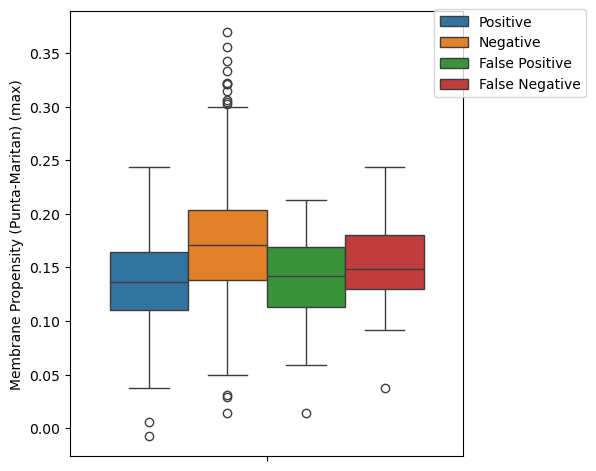

In [46]:
sns.boxplot(
    data=punta_ready,
    y="Membrane Propensity (Punta-Maritan) (max)",
    hue="Group" 
)
plt.legend(loc='upper right', bbox_to_anchor=(1.33, 1.02))
plt.tight_layout()
plt.savefig("model_evaluation/Boxplot_PuntaMaritan.png", dpi=300)
plt.show()

In [47]:
# mean residue bulkiness

bulkiness_scale = { "A": 11.500  , "R": 14.280  , "N": 12.820  ,"D": 11.680  ,"C": 13.460  ,"Q": 14.450  ,"E": 13.570  ,"G":  3.400  , "H": 13.690  , "I": 21.400  , "L": 21.400  , "K": 15.710  , "M": 16.250  , "F": 19.800  , "P": 17.430  , "S":  9.470  , "T": 15.770  , "W": 21.670  , "Y": 18.030  ,  "V": 21.570 }
bulk = scale_function(prediction_dataset["Sequence"], bulkiness_scale, "mean")

In [48]:
#create bulk dataframes

bulk_df = prediction_dataset.copy()
bulk_df["Mean residue bulkiness"]=bulk

bulk_all_positives=bulk_df.query("Class == 'Positive'")
bulk_all_positives["Group"]="Positive"

bulk_all_negatives=bulk_df.query("Class == 'Negative'")
bulk_all_negatives["Group"]="Negative"

bulk_fp=bulk_df.query("Prediction == 'FP'")
bulk_fp["Group"]="False Positive"

bulk_fn=bulk_df.query("Prediction == 'FN'")
bulk_fn["Group"]="False Negative"

bulk_ready = pd.concat([bulk_all_positives , bulk_all_negatives , bulk_fp , bulk_fn] , axis=0 )

#### Bulkiness plot

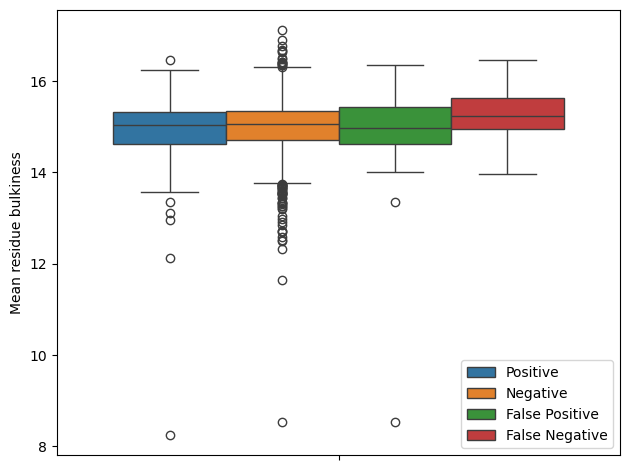

In [49]:
sns.boxplot(
    data=bulk_ready,
    y="Mean residue bulkiness",
    hue="Group" 
)
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig("model_evaluation/boxplot_Bulkiness.png", dpi=300)
plt.show()

In [50]:
# argos (empiric measure based on lateral chain solvent accessibility --> hydrophobicity measure)

argos_max = scale_function(prediction_dataset["Sequence"], "ag", "max")

In [51]:
#create argos dataframes

argos_df = prediction_dataset.copy()
argos_df["Residue Hydrophobicity (argos - max)"]=argos_max

argos_all_positives=argos_df.query("Class == 'Positive'")
argos_all_positives["Group"]="Positive"

argos_all_negatives=argos_df.query("Class == 'Negative'")
argos_all_negatives["Group"]="Negative"

argos_fp=argos_df.query("Prediction == 'FP'")
argos_fp["Group"]="False Positive"

argos_fn=argos_df.query("Prediction == 'FN'")
argos_fn["Group"]="False Negative"

argos_ready = pd.concat([argos_all_positives , argos_all_negatives , argos_fp , argos_fn] , axis=0 )

#### Argos plot

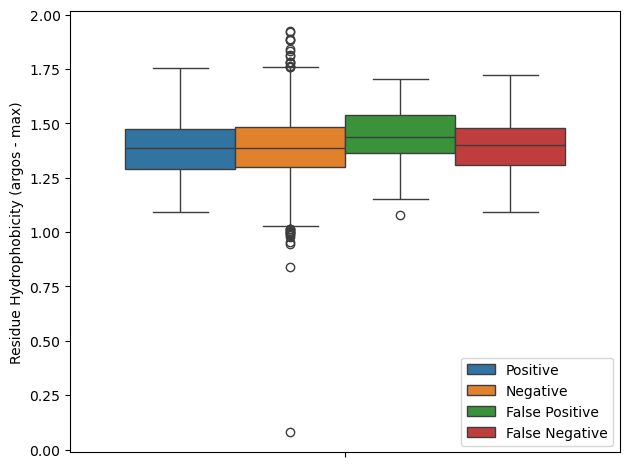

In [52]:
sns.boxplot(
    data=argos_ready,
    y="Residue Hydrophobicity (argos - max)",
    hue="Group" 
)
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig("model_evaluation/Boxplot_ArgosMax.png", dpi=300)
plt.show()